In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split
from PIL import Image
import matplotlib.pyplot as plt

In [6]:
# Define transformations for preprocessing
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize image to 224x224
    transforms.ToTensor(),  # Convert image to PyTorch tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize image
])

In [7]:

# Function to check if image is valid
def is_valid_image(image_path):
    try:
        # Attempt to open and validate the image
        Image.open(image_path).convert('RGB')
        return True
    except (FileNotFoundError, OSError, ValueError):
        return False

# Custom dataset class with error handling
class CustomImageFolder(ImageFolder):
    def __init__(self, root, transform=None):
        super().__init__(root, transform=transform)

    def __getitem__(self, index):
        # Get image path and label from original ImageFolder
        path, target = self.samples[index]

        # Check if image is valid
        if not is_valid_image(path):
            # Handle invalid image (e.g., return a placeholder image or skip)
            # For simplicity, returning a placeholder image and an out-of-bounds target
            invalid_image = torch.zeros((3, 224, 224))  # Placeholder image tensor
            return invalid_image, len(self.classes)  # Return an out-of-bounds target

        # Load and transform the image
        image = self.loader(path)
        if self.transform is not None:
            image = self.transform(image)

        return image, target

In [20]:
# Load the custom dataset
dataset_path = 'C:/Users/aryan/Desktop/WORK/Summer Research Internship/Pear/leaves'  # Change this to the actual dataset path
dataset = CustomImageFolder(dataset_path, transform=transform)

# Split the dataset into training and validation sets
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Define the DataLoader
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [21]:
# Define the Channel Shuffle utility
class ChannelShuffle(nn.Module):
    def __init__(self, groups):
        super(ChannelShuffle, self).__init__()
        self.groups = groups

    def forward(self, x):
        batchsize, num_channels, height, width = x.data.size()
        channels_per_group = num_channels // self.groups
        # Reshape
        x = x.view(batchsize, self.groups, channels_per_group, height, width)
        # Transpose
        x = torch.transpose(x, 1, 2).contiguous()
        # Flatten
        x = x.view(batchsize, -1, height, width)
        return x

In [22]:
# Define the Coordinate Attention Module (CoordAtt)
class CoordAtt(nn.Module):
    def __init__(self, in_channels, reduction=32):
        super(CoordAtt, self).__init__()
        self.pool_h = nn.AdaptiveAvgPool2d((None, 1))
        self.pool_w = nn.AdaptiveAvgPool2d((1, None))
        
        mip = max(8, in_channels // reduction)
        self.conv1 = nn.Conv2d(in_channels, mip, kernel_size=1, stride=1, padding=0)
        self.bn1 = nn.BatchNorm2d(mip)
        self.act = nn.ReLU(inplace=True)
        
        self.conv_h = nn.Conv2d(mip, in_channels, kernel_size=1, stride=1, padding=0)
        self.conv_w = nn.Conv2d(mip, in_channels, kernel_size=1, stride=1, padding=0)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        identity = x
        n, c, h, w = x.size()
        
        x_h = self.pool_h(x)
        x_w = self.pool_w(x).permute(0, 1, 3, 2)
        
        y = torch.cat([x_h, x_w], dim=2)
        y = self.conv1(y)
        y = self.bn1(y)
        y = self.act(y)
        
        x_h, x_w = torch.split(y, [h, w], dim=2)
        x_w = x_w.permute(0, 1, 3, 2)
        
        a_h = self.sigmoid(self.conv_h(x_h))
        a_w = self.sigmoid(self.conv_w(x_w))
        
        out = identity * a_h * a_w
        return out


In [23]:
# Define the RCSA module
class RCSA(nn.Module):
    def __init__(self, in_channels, reduction=16, groups=4):
        super(RCSA, self).__init__()
        self.groups = groups
        self.channel_shuffle = ChannelShuffle(groups)
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.conv1 = nn.Conv2d(in_channels, in_channels // reduction, 1, bias=False)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(in_channels // reduction, in_channels, 1, bias=False)
        self.coord_att = CoordAtt(in_channels)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        residual = x
        # Channel Shuffle
        x = self.channel_shuffle(x)
        # Squeeze and Excitation
        x = self.avg_pool(x)
        x = self.conv1(x)
        x = self.relu(x)
        x = self.conv2(x)
        # Coordinate Attention
        x = self.coord_att(x)
        x = self.sigmoid(x)
        # Scale
        x = residual * x
        return x

In [24]:
class CustomCNN(nn.Module):
    def __init__(self, num_classes):
        super(CustomCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1)
        self.rcsa1 = RCSA(64)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.rcsa2 = RCSA(128)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        self.rcsa3 = RCSA(256)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.fc1 = nn.Linear(256 * 28 * 28, 128)  # Adjust input size based on your image dimensions after pooling
        self.fc2 = nn.Linear(128, num_classes)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.rcsa1(x)
        x = self.pool1(x)
        
        x = self.relu(self.conv2(x))
        x = self.rcsa2(x)
        x = self.pool2(x)
        
        x = self.relu(self.conv3(x))
        x = self.rcsa3(x)
        x = self.pool3(x)
        
        x = x.view(x.size(0), -1)  # Flatten the tensor
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [25]:
# Initialize the model
model = CustomCNN(num_classes=len(dataset.classes))

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss(ignore_index=len(dataset.classes))  # Ignore the out-of-bounds target
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [26]:
# Function to calculate accuracy
def calculate_accuracy(outputs, labels):
    _, predicted = torch.max(outputs, 1)
    correct = (predicted == labels).sum().item()
    total = labels.size(0)
    accuracy = correct / total * 100
    return accuracy

In [27]:
# Training loop with validation
num_epochs = 25
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    train_loss = running_loss / len(train_loader)
    train_accuracy = correct_train / total_train * 100
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    model.eval()
    running_val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    val_loss = running_val_loss / len(val_loader)
    val_accuracy = correct_val / total_val * 100 
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}%, Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.2f}%')


Epoch [1/25], Train Loss: 0.7467, Train Acc: 66.60%, Val Loss: 0.5671, Val Acc: 75.25%
Epoch [2/25], Train Loss: 0.5609, Train Acc: 74.63%, Val Loss: 0.4771, Val Acc: 78.74%
Epoch [3/25], Train Loss: 0.4655, Train Acc: 79.28%, Val Loss: 0.4496, Val Acc: 79.73%
Epoch [4/25], Train Loss: 0.3953, Train Acc: 82.36%, Val Loss: 0.4118, Val Acc: 81.89%
Epoch [5/25], Train Loss: 0.3158, Train Acc: 86.31%, Val Loss: 0.4446, Val Acc: 82.23%
Epoch [6/25], Train Loss: 0.2129, Train Acc: 91.51%, Val Loss: 0.4589, Val Acc: 83.72%
Epoch [7/25], Train Loss: 0.1220, Train Acc: 95.42%, Val Loss: 0.5625, Val Acc: 82.89%
Epoch [8/25], Train Loss: 0.0803, Train Acc: 96.76%, Val Loss: 0.7279, Val Acc: 80.40%
Epoch [9/25], Train Loss: 0.0437, Train Acc: 98.46%, Val Loss: 0.7163, Val Acc: 85.05%
Epoch [10/25], Train Loss: 0.0171, Train Acc: 99.58%, Val Loss: 0.8431, Val Acc: 85.71%
Epoch [11/25], Train Loss: 0.0073, Train Acc: 99.75%, Val Loss: 0.9053, Val Acc: 84.22%
Epoch [12/25], Train Loss: 0.0019, Train 

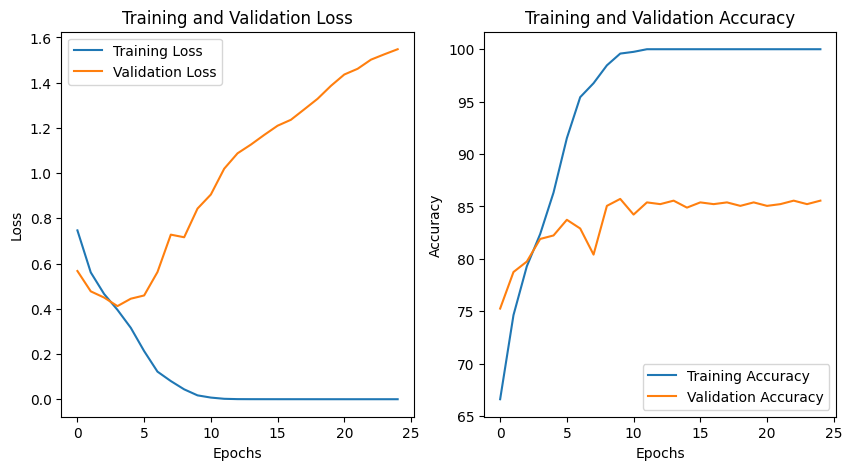

In [28]:
# Plotting the training and validation loss
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(range(num_epochs), train_losses, label='Training Loss')
plt.plot(range(num_epochs), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

# Plotting the training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(range(num_epochs), train_accuracies, label='Training Accuracy')
plt.plot(range(num_epochs), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

plt.show()